In [92]:
import torch
from torch import nn
import torch.nn.functional as F
from ntm import NTM
from sequence_generator import *
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython import display
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [99]:
class RNN(nn.Module):
    def __init__(self, input_size=9, hidden_size=100, output_size=9):
        super(RNN, self).__init__()
        MAX = 1024
        EOS = torch.from_numpy(np.array(8*[0] + [1])).float()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = torch.nn.functional.sigmoid
        self.hidden_state0 = Parameter(torch.zeros(1, hidden_size)).float()
        self.cell_state0 = Parameter(torch.zeros(1, hidden_size)).float()
        self.zero_vector = Parameter(torch.zeros(MAX, 9)).float()
        #self.zero_vector = Parameter(EOS.expand(MAX, 9))
        
    def step(self, input_vector, hidden_state, cell_state):
        hidden_state, cell_state = self.LSTM(input_vector, (hidden_state, cell_state))
        return hidden_state, cell_state, self.fc(hidden_state)
    
    def forward(self, input_vectors):
        N = input_vectors.shape[0]
        T = input_vectors.shape[1] - 1
        
        hidden_state = self.hidden_state0.expand(N, self.hidden_size)
        cell_state = self.cell_state0.expand(N, self.hidden_size)
        
        for t in range(T + 1):
            hidden_state, cell_state, _ = self.step(input_vectors[:, t, :], hidden_state, cell_state)
        
        
        outputs = []
        for t in range(T):
            hidden_state, cell_state, output = self.step(self.zero_vector[:N,:], hidden_state, cell_state)
            outputs.append(self.activation(output.unsqueeze(2).transpose(1, 2)))
        return torch.cat(outputs, 1)


In [94]:
ntmlstm = torch.load('sbatch/logs/04_02/14_24_42_LSTM_RMS_N=128_M=20_min_l=1_batch=1_lr=0.0001/ntm.pkl')
ntmmlp = torch.load('sbatch/logs/04_02/14_13_53_MLP_RMS_N=128_M=20_min_l=1_batch=1_lr=0.0001/ntm.pkl')

In [95]:
def get_in_and_out(seq_len, ntm=ntmmlp):
    ntm.reset()
    inp = create_sequence(seq_len=seq_len, batch_size=1, cuda=cuda)
    for i in range(inp.size(0)):
        ntm.send(inp[i])
    outs = []

    for i in range(inp.size(0) - 1):
        x = ntm.receive(input_zero)
        outs.append(F.sigmoid(x))
    out = torch.stack(outs)
    return inp.transpose(0, 1)[0].data.cpu().numpy().T, out.transpose(0,1 )[0].data.cpu().numpy().T


MLP


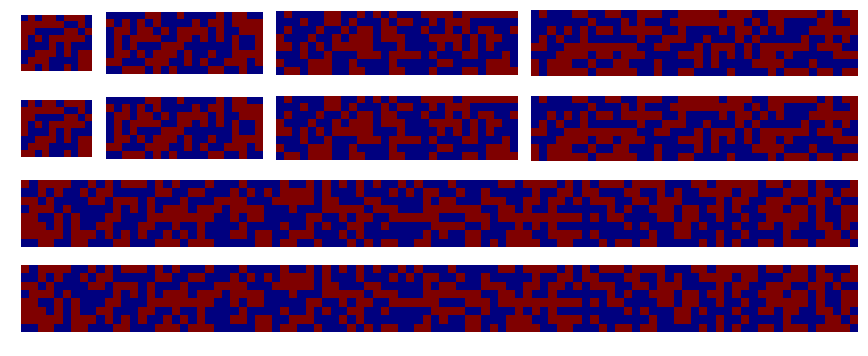

In [108]:
plt.rcParams['figure.figsize'] = (15, 6)
ax11 = plt.subplot2grid((4, 10), (0, 0))
ax12 = plt.subplot2grid((4, 10), (0, 1), colspan=2)
ax13 = plt.subplot2grid((4, 10), (0, 3), colspan=3)
ax14 = plt.subplot2grid((4, 10), (0, 6), colspan=4)
ax21 = plt.subplot2grid((4, 10), (1, 0))
ax22 = plt.subplot2grid((4, 10), (1, 1), colspan=2)
ax23 = plt.subplot2grid((4, 10), (1, 3), colspan=3)
ax24 = plt.subplot2grid((4, 10), (1, 6), colspan=6)
ax30 = plt.subplot2grid((4, 10), (2, 0), colspan=10)
ax40 = plt.subplot2grid((4, 10), (3, 0), colspan=10)
axes = [ax11, ax12, ax13, ax14, ax21, ax22, ax23, ax24, ax30, ax40]
for ax in axes:
    ax.axis('off')
print('MLP')
inp, out = get_in_and_out(10)
ax11.imshow(inp[:-1,:-1], cmap='jet')
ax21.imshow(out[:,:], cmap='jet')
#ax21.imshow(np.abs(out[:,:] - inp[:-1,:-1]), cmap='jet')

inp, out = get_in_and_out(20)
ax12.imshow(inp[:-1,:-1], cmap='jet')
ax22.imshow(out[:,:], cmap='jet')
#ax22.imshow(np.abs(out[:,:] - inp[:-1,:-1]), cmap='jet')

inp, out = get_in_and_out(30)
ax13.imshow(inp[:-1,:-1], cmap='jet')
ax23.imshow(out[:,:], cmap='jet')
#ax23.imshow(np.abs(out[:,:] - inp[:-1,:-1]), cmap='jet')

inp, out = get_in_and_out(40)
ax14.imshow(inp[:-1,:-1], cmap='jet')
ax24.imshow(out[:,:], cmap='jet')
#ax24.imshow(np.abs(out[:,:] - inp[:-1,:-1]), cmap='jet')

inp, out = get_in_and_out(100)
ax30.imshow(inp[:-1,:-1], cmap='jet')
ax40.imshow(out[:,:], cmap='jet')
#ax40.imshow(np.abs(out[:,:] - inp[:-1,:-1]), cmap='jet')
plt.show()

LSTM


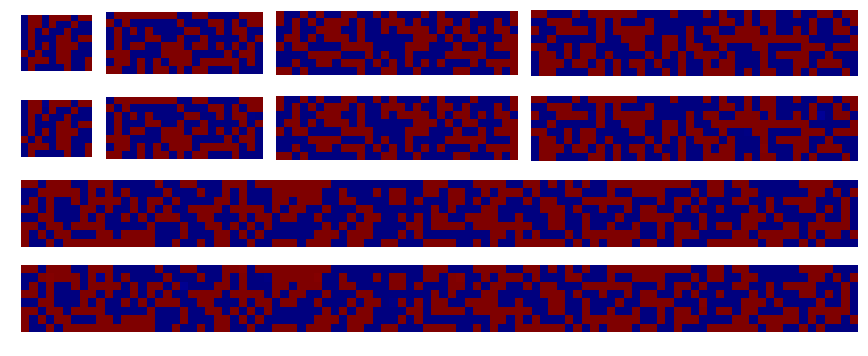

In [107]:
plt.rcParams['figure.figsize'] = (15, 6)
ax11 = plt.subplot2grid((4, 10), (0, 0))
ax12 = plt.subplot2grid((4, 10), (0, 1), colspan=2)
ax13 = plt.subplot2grid((4, 10), (0, 3), colspan=3)
ax14 = plt.subplot2grid((4, 10), (0, 6), colspan=4)
ax21 = plt.subplot2grid((4, 10), (1, 0))
ax22 = plt.subplot2grid((4, 10), (1, 1), colspan=2)
ax23 = plt.subplot2grid((4, 10), (1, 3), colspan=3)
ax24 = plt.subplot2grid((4, 10), (1, 6), colspan=6)
ax30 = plt.subplot2grid((4, 10), (2, 0), colspan=10)
ax40 = plt.subplot2grid((4, 10), (3, 0), colspan=10)
axes = [ax11, ax12, ax13, ax14, ax21, ax22, ax23, ax24, ax30, ax40]
for ax in axes:
    ax.axis('off')
print('LSTM')
inp, out = get_in_and_out(10, ntmlstm)
ax11.imshow(inp[:-1,:-1], cmap='jet')
ax21.imshow(out[:,:], cmap='jet')

inp, out = get_in_and_out(20, ntmlstm)
ax12.imshow(inp[:-1,:-1], cmap='jet')
ax22.imshow(out[:,:], cmap='jet')

inp, out = get_in_and_out(30, ntmlstm)
ax13.imshow(inp[:-1,:-1], cmap='jet')
ax23.imshow(out[:,:], cmap='jet')

inp, out = get_in_and_out(40, ntmlstm)
ax14.imshow(inp[:-1,:-1], cmap='jet')
ax24.imshow(out[:,:], cmap='jet')

inp, out = get_in_and_out(100, ntmlstm)
ax30.imshow(inp[:-1,:-1], cmap='jet')
ax40.imshow(out[:,:], cmap='jet')
plt.show()

In [100]:
%run loadpkl.py
rnn = lstmk
def generate_sequences(nb_batches, max_len=10, mini_batch_size=10):
    # module = torch.cuda if cuda else torch
    #print(1)
    for batch_idx in range(nb_batches):
        # yield one batch
        T = np.random.randint(1, max_len + 1)
        #T = np.random.choice(list(range(1, max_len + 1)), 1, p=np.arange(1, max_len+1) * 2./((max_len+1) * (max_len)))[0]
        X = np.random.randint(0, 2, (mini_batch_size, T + 1, 9)).astype(float)
        X[:, :, -1] = np.array(T*[0]+[1])
        X[:, -1, :-1] = np.array(8 * [0])


        yield Variable(torch.from_numpy(X)).float()  
        
def generate_sequences_fixed_length(nb_batches, length=10, mini_batch_size=10):
    # module = torch.cuda if cuda else torch
    #print(1)
    for batch_idx in range(nb_batches):
        # yield one batch
        T = length
        X = np.random.randint(0, 2, (mini_batch_size, T + 1, 9)).astype(float)
        X[:, :, -1] = np.array(T*[0]+[1])
        X[:, -1, :-1] = np.array(8 * [0])


        yield Variable(torch.from_numpy(X)).float()  

/u/lahlosal/.conda/envs/deep/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class '__main__.RNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Vanilla LSTM


AttributeError: 'AxesSubplot' object has no attribute 'cmap'

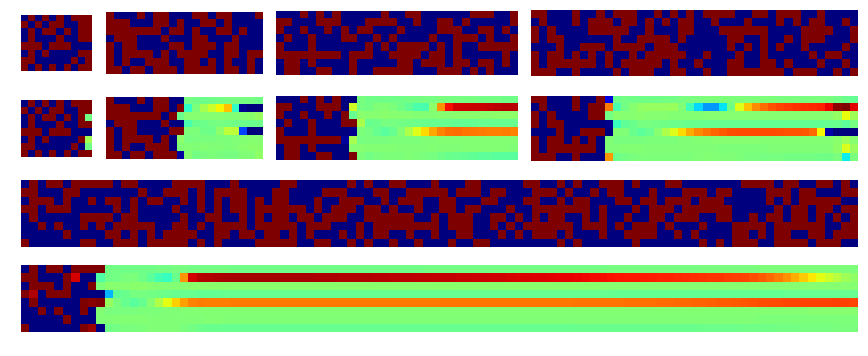

In [109]:
plt.rcParams['figure.figsize'] = (15, 6)
ax11 = plt.subplot2grid((4, 10), (0, 0))
ax12 = plt.subplot2grid((4, 10), (0, 1), colspan=2)
ax13 = plt.subplot2grid((4, 10), (0, 3), colspan=3)
ax14 = plt.subplot2grid((4, 10), (0, 6), colspan=4)
ax21 = plt.subplot2grid((4, 10), (1, 0))
ax22 = plt.subplot2grid((4, 10), (1, 1), colspan=2)
ax23 = plt.subplot2grid((4, 10), (1, 3), colspan=3)
ax24 = plt.subplot2grid((4, 10), (1, 6), colspan=6)
ax30 = plt.subplot2grid((4, 10), (2, 0), colspan=10)
ax40 = plt.subplot2grid((4, 10), (3, 0), colspan=10)
axes = [ax11, ax12, ax13, ax14, ax21, ax22, ax23, ax24, ax30, ax40]
for ax in axes:
    ax.axis('off')
print('Vanilla LSTM')
test = list(generate_sequences_fixed_length(1, 10 ,7))[0].cuda()
out = rnn(test)

real = test[0].data.cpu().numpy().T
trial = out[0].data.cpu().numpy().T
ax11.imshow(real[:-1,:-1], cmap='jet')
ax21.imshow(trial[:-1,:], cmap='jet')

test = list(generate_sequences_fixed_length(1, 20 ,7))[0].cuda()
out = rnn(test)
real = test[0].data.cpu().numpy().T
trial = out[0].data.cpu().numpy().T
ax12.imshow(real[:-1,:-1], cmap='jet')
ax22.imshow(trial[:-1,:], cmap='jet')

test = list(generate_sequences_fixed_length(1, 30 ,7))[0].cuda()
out = rnn(test)
real = test[0].data.cpu().numpy().T
trial = out[0].data.cpu().numpy().T
ax13.imshow(real[:-1,:-1], cmap='jet')
ax23.imshow(trial[:-1,:], cmap='jet')

test = list(generate_sequences_fixed_length(1, 40 ,7))[0].cuda()
out = rnn(test)
real = test[0].data.cpu().numpy().T
trial = out[0].data.cpu().numpy().T
ax14.imshow(real[:-1,:-1], cmap='jet')
ax24.imshow(trial[:-1,:], cmap='jet')

test = list(generate_sequences_fixed_length(1, 100 ,7))[0].cuda()
out = rnn(test)
real = test[0].data.cpu().numpy().T
trial = out[0].data.cpu().numpy().T
ax30.imshow(real[:-1,:-1], cmap='jet')
ax40.imshow(trial[:-1,:], cmap='jet')
ax40.cmap()
plt.show()